In [1]:
from collections import deque
import numpy as np
import gym
from gym import wrappers
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
np.random.seed(100)

In [3]:
# References
# https://pdfs.semanticscholar.org/2820/01869bd502c7917db8b32b75593addfbbc68.pdf
# http://ceur-ws.org/Vol-547/81.pdf
# http://rll.berkeley.edu/deeprlcourse/f17docs/lecture_7_advanced_q_learning.pdf

A Q learner using 2 layer MLP to approximate the Q function parameterized by $\phi$. We use MSE with a gradient descent optimizer for training. The learner follows an epsilon greedy strategy with epsilon decay, and samples from memory through experience replay at each step.

The "label" $Q(s_t,a_t)$ is approximated by $ r + \gamma\max_a Q(s_{t+1},a_{t+1})$ to compute the bellman error $$r + \gamma\max_a Q_{\phi}(s_{t+1},a_{t+1})-Q_{\phi}(s_t,a_t)$$

We can continue this exercise by: 
1. Implementing a target $Q_{\phi'}(s,a)$ to address the moving target issue raised in the literature.
2. Using Polyak averaging to update the target Q function.
3. Use Huber loss in place of MSE for gradient clipping.
4. Implement batch updates.



INFO:gym.envs.registration:Making new env: FrozenLake-v0
[2017-11-16 12:03:49,714] Making new env: FrozenLake-v0


Episode: 0 Total Reward: 1.0 Loss: 0.000199528803932 Ratio: 0.0
Episode: 50 Total Reward: 0.0 Loss: 2.0993529688e-06 Ratio: 0.06
Episode: 100 Total Reward: 0.0 Loss: 0.0269461330026 Ratio: 0.1
Episode: 150 Total Reward: 0.0 Loss: 1.55067300511e-06 Ratio: 0.095
Episode: 200 Total Reward: 0.0 Loss: 4.34480307376e-06 Ratio: 0.12
Episode: 250 Total Reward: 1.0 Loss: 0.00040782688302 Ratio: 0.1
Episode: 300 Total Reward: 0.0 Loss: 3.77302712877e-05 Ratio: 0.102857142857
Episode: 350 Total Reward: 0.0 Loss: 1.08318999992e-06 Ratio: 0.105
Episode: 400 Total Reward: 0.0 Loss: 1.85881490324e-05 Ratio: 0.117777777778
Episode: 450 Total Reward: 1.0 Loss: 0.000140996606206 Ratio: 0.134
Episode: 500 Total Reward: 0.0 Loss: 7.92183800513e-06 Ratio: 0.121818181818
Episode: 550 Total Reward: 0.0 Loss: 2.39538931055e-05 Ratio: 0.135
Episode: 600 Total Reward: 0.0 Loss: 0.0323208868504 Ratio: 0.141538461538
Episode: 650 Total Reward: 0.0 Loss: 0.0281984005123 Ratio: 0.157142857143
Episode: 700 Total Rew

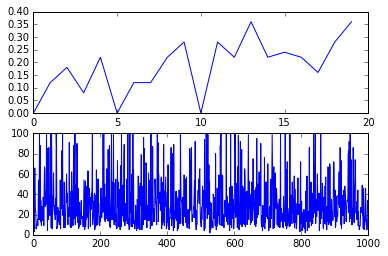

In [4]:
class QLearner(object):
    def __init__(self,
                 sess,
                 n_state,
                 n_hidden,
                 n_action,
                 max_episodes,
                 lr,
                 env,
                 gamma,
                 epsilon,
                 decay):
        self.sess = sess
        self.n_state = n_state
        self.n_hidden = n_hidden
        self.n_action = n_action
        self.max_episodes = max_episodes
        self.lr = lr
        self._assemble()
        
        # Parameters related to agent.
        self.env = env
        self.gamma = gamma
        self.epsilon = epsilon
        self.min_eps = 0.02
        self.max_eps = self.epsilon
        self.decay = decay
        self.total_rs = []
        self.total_steps = []
        self.success_rates = []
        self.memory = deque(maxlen=10000)
    
    
    def _init_weights(self, shape):
        return tf.Variable(tf.random_uniform(shape))
    
    def _reshape(self, x):
        return np.array(x).reshape(-1,self.n_state)

    def _model(self, X, w_h1, w_o):
        h1 = tf.nn.relu(tf.matmul(X, w_h1))
        return tf.matmul(h1, w_o)

    def _assemble(self):
        """ Builds graph """
        # Create placeholders.
        self.obs = tf.placeholder("float", [None, self.n_state])
        self.target = tf.placeholder("float", [None, self.n_action])
        
        # Create variables and initialize.
        self.w_h1 = self._init_weights([self.n_state, self.n_hidden])
        self.w_o = self._init_weights([self.n_hidden, self.n_action])
  
        # Creates inference model.
        self.q = self._model(self.obs, self.w_h1, self.w_o)
        self.predict = tf.argmax(self.q,1)
        
        self.loss = tf.losses.mean_squared_error(predictions=self.q, labels=self.target)
        self.trainer = tf.train.GradientDescentOptimizer(self.lr)
        self.step = self.trainer.minimize(self.loss)

    def _experience_replay(self):
        sample_size = len(self.memory) if len(self.memory) < 32 else 32
        i_sample = np.random.choice(xrange(len(self.memory)), sample_size)
        
        for i in i_sample:
            s0_, a_, r_, s1_, done_ = self.memory[i]
            s1_ = np.identity(16)[s1_]
            q0_ = self.sess.run([self.q], feed_dict={self.obs: self._reshape(s0_)})
            q1_ = self.sess.run([self.q], feed_dict={self.obs: self._reshape(s1_)})
            
            # Construct q target for loss calculation.
            q_target = np.array(q0_).reshape(-1, self.n_action)
            q_target[0,a_[0]] = r_ + self.gamma * np.max(q1_)*(1-done_)

            loss,_,_,_ = self.sess.run([self.loss, self.step, self.w_h1, self.w_o ],feed_dict={
                            self.obs: self._reshape(s0_),
                            self.target:q_target
                        })
            
        # Return last computed loss to print out
        return loss
    
    def train(self):
        tf.global_variables_initializer().run()
        steps = 0
        for i in range(self.max_episodes):
            s0 = env.reset()
            total_r = 0
            done = False
            step = 0
            while step < 100:
                step +=1
                s0 = np.identity(16)[s0]
                a, q0 = self.sess.run([self.predict, self.q], feed_dict={self.obs: self._reshape(s0)})
                if np.random.uniform(1) < self.epsilon:
                    a[0] = self.env.action_space.sample()
                    
                s1, r, done, _ = env.step(a[0])
                self.memory.append((s0, a, r, s1, done))
                loss = self._experience_replay()
                total_r += r
                s0 = s1
            
                if done:
                    self.epsilon = self.min_eps + (self.max_eps- self.min_eps) * np.exp(-self.decay * i)
                    break
                    
            self.total_rs.append(total_r)
            self.total_steps.append(step)
                
            if i % 50 == 0:
                ratio = self.evaluate()
                self.success_rates.append(ratio)
                print("Episode: {} Total Reward: {} Loss: {} Ratio: {}".format(
                        i, total_r, loss, np.mean(self.success_rates)))
                
    def evaluate(self):
        episode_r = 0
        for i in range(50):
            s = env.reset()
            done = False
            while not done:
                s = np.identity(16)[s]
                a, _ = self.sess.run([self.predict, self.q], feed_dict={self.obs: self._reshape(s)})
                s, r, done, _ = env.step(a[0])
                episode_r += r
        return episode_r/50.


                
gamma = 0.99
episodes = 1000
epsilon = 0.1
lr = 0.1
decay = 0.0002
env = gym.make('FrozenLake-v0')

tf.reset_default_graph()
with tf.Session() as sess:
    agent = QLearner(sess, 16, 16, 4, episodes,lr, env, gamma, epsilon, decay)
    agent.train()
    plt.figure(1)
    plt.subplot(211)
    plt.plot(agent.success_rates)
    plt.subplot(212)
    plt.plot(agent.total_steps)

